# Preliminaries

## Importing Libraries

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy, LiederPolicy
from joblib import Parallel, delayed
from evaluation import *
import json

import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Verifying new reward function

In [5]:
from scipy.stats import norm
def discrete_normal(mu, sigma, discretization):
    d = norm(0, sigma)
    vals = np.linspace(-2*sigma, 2*sigma, discretization)
    delta = vals[1] - vals[0]
    bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
    probs = np.diff(d.cdf(bins))
    return Categorical(vals, probs)

In [6]:
reward = discrete_normal(0, sigma = 10, discretization = 6)

In [7]:
print(reward)

Categorical(vals=[-20. -12.  -4.   4.  12.  20.], probs=[ 0.055  0.157  0.288  0.288  0.157  0.055])


In [8]:
dist = Normal(0,10)
reward = dist.to_discrete(6)

In [9]:
print(reward)

Categorical(vals=[-20. -12.  -4.   4.  12.  20.], probs=[ 0.055  0.157  0.288  0.288  0.157  0.055])


## Verifying making new environments

In [10]:
def make_env(depth, reward, cost, ground_truth=False):
    """Returns a MouselabEnv with given depth and cost. 
    If `ground_truth` is True, the reward observed at a given node will be
    constant across runs on this env. This reduces variance of the return."""
    env = MouselabEnv(depth, reward=reward, cost=cost)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(depth, reward, cost, n=100, ground_truth=None):
    # Note, ground_truth can be an int in which case it acts as a random seed.
    if ground_truth is not None:
        np.random.seed(ground_truth)
        return [make_env(depth, reward, cost, True) for _ in range(n)]
    else:
        return [make_env(depth, reward, cost, False)] * n

In [11]:
dist = Normal(0,10)
reward = dist.to_discrete(6)
cost=0.01
env1 = MouselabEnv([4,1,2], reward=reward,cost=cost)
env2 = make_env([4,1,2], reward, cost, ground_truth=False)
env3 = make_env([4,1,2], reward, cost, ground_truth=True)

In [29]:
def relevant_action(env, action):
    return (*env.path_to(action)[1:], *env.subtree[action][1:])

for a in range(1,17):
    print(list(relevant_action(env1, a)))

[1, 2, 3, 4]
[1, 2, 3, 4]
[1, 2, 3]
[1, 2, 4]
[5, 6, 7, 8]
[5, 6, 7, 8]
[5, 6, 7]
[5, 6, 8]
[9, 10, 11, 12]
[9, 10, 11, 12]
[9, 10, 11]
[9, 10, 12]
[13, 14, 15, 16]
[13, 14, 15, 16]
[13, 14, 15]
[13, 14, 16]


In [12]:
print('--env1---')
print('reward = '+str(env1.reward))
print('cost = '+str(env1.cost))
print('branch = '+str(env1.branch))
print('--env2---')
print('reward = '+str(env2.reward))
print('cost = '+str(env2.cost))
print('branch = '+str(env2.branch))
print('--env3---')
print('reward = '+str(env3.reward))
print('cost = '+str(env3.cost))
print('branch = '+str(env3.branch))
print('ground truth ='+str(env3.ground_truth))

--env1---
reward = Categorical(vals=[-20. -12.  -4.   4.  12.  20.], probs=[ 0.055  0.157  0.288  0.288  0.157  0.055])
cost = -0.01
branch = [4, 1, 2]
--env2---
reward = Categorical(vals=[-20. -12.  -4.   4.  12.  20.], probs=[ 0.055  0.157  0.288  0.288  0.157  0.055])
cost = -0.01
branch = [4, 1, 2]
--env3---
reward = Categorical(vals=[-20. -12.  -4.   4.  12.  20.], probs=[ 0.055  0.157  0.288  0.288  0.157  0.055])
cost = -0.01
branch = [4, 1, 2]
ground truth =[  0.  12.  12.   4.  20.  -4. -12.   4.  20. -20.  -4. -12.   4.  12.   4.  -4.  -4.]


In [10]:
train_envs = make_envs([4,1,2], reward, cost,n=1000, ground_truth=1)

In [12]:
train_envs = make_envs([4,1,2], reward, cost,n=1000, ground_truth=1)
bo_pol,result = bo_policy(train_envs, max_cost=30, n_calls = 20,n_jobs=20,
                        verbose=0, normalize_voi=False, return_result=True)

In [ ]:
x2theta(result.x, normalize_voi=False)

In [ ]:
bo_pol.theta

## Data saving conventions

In [13]:
def filename(cost, normalize):
    c = round(float(cost), 5)
    n = int(normalize)
    return 'data/tree_{}_{}'.format(c, n)

In [14]:
fn = filename(cost, True)
print(fn + '.npy')

data/tree_0.01_1.npy


# Training and Testing

## Training and testing across different methods

In [28]:
#Rerun with unnormalized BO and regression to get separate df, combine them outside
def run_params(cost=.01):
    dist = Normal(0,10)
    reward = dist.to_discrete(6)
    train_envs = make_envs([4,1,2], reward, cost, n=1000, ground_truth=1)
    term_action = train_envs[0].term_action
#     write_bo_policy(n_arm, max_obs, cost,n_calls = 10)
    bo_pol,result = bo_policy(train_envs, max_cost=30, n_calls = 60, n_jobs=20,
                        verbose=0, normalize_voi=True, return_result=True)
    policies = {
#         'BO': bo_policy(train_envs, max_cost=30, n_calls = 10),
        'BO' : bo_pol,
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'object-myopic2': FixedPlanPolicy([1,5,9,13,term_action])
    }
    fn = filename(cost, True)
    np.save(fn + '.npy', bo_pol.theta)
    
    test_envs = make_envs([4,1,2], reward, cost,n=500, ground_truth=1)
    
    def test():
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['cost'] = cost
            yield df
    return pd.concat(test())

In [ ]:
data = []
datapts = 3
costs = [0.25,1,4]
for i in range(datapts):
    cost = costs[i]
    print('cost = ' + str(cost))
    data.append(run_params(cost = cost))
#     run_params(cost = cost)
    
store = pd.HDFStore('tests500.h5')
store['data'] = pd.concat(data)
store.close()

In [20]:
store = pd.HDFStore('tests500.h5')
df = pd.concat([store['data'],store['om_only']])
print(df.groupby(['cost','agent']).util.mean())

cost  agent           
0.25  BO                  1.997900e+01
      full-observation    1.867200e+01
      meta-greedy         1.793000e+01
      object-myopic2      8.440000e+00
1.00  BO                  1.303400e+01
      full-observation    6.672000e+00
      meta-greedy         1.203000e+01
      object-myopic2      5.440000e+00
4.00  BO                 -4.440892e-16
      full-observation   -4.132800e+01
      meta-greedy        -1.600000e-02
      object-myopic2     -6.560000e+00
Name: util, dtype: float64


(0, 20.0)

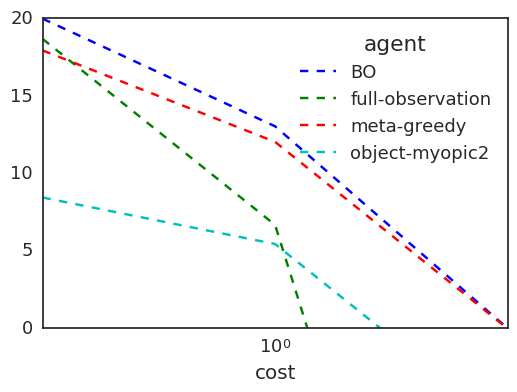

In [21]:
(df.groupby(['cost','agent'])
    .util.mean().unstack()
    .plot(logx=True, ls='--', by='n_arm'))
plt.ylim(0)

## Creating JSON files

In [15]:
stimuli_envs = make_envs([4,1,2], reward, cost,n=16, ground_truth=1)

In [16]:
reward_list = [{'stateRewards': list(env.ground_truth)} for env in stimuli_envs]

In [17]:
for i in range(16):
    reward_list[i]['trial_id'] = i

In [18]:
reward_list[:2]

[{'stateRewards': [0.0,
   -4.0,
   4.0,
   -20.0,
   -4.0,
   -12.0,
   -12.0,
   -12.0,
   -4.0,
   -4.0,
   4.0,
   -4.0,
   4.0,
   -12.0,
   12.0,
   -20.0,
   4.0],
  'trial_id': 0},
 {'stateRewards': [0.0,
   -4.0,
   4.0,
   -12.0,
   -12.0,
   12.0,
   20.0,
   -4.0,
   4.0,
   12.0,
   12.0,
   -12.0,
   -20.0,
   -12.0,
   12.0,
   -12.0,
   -4.0],
  'trial_id': 1}]

In [19]:
first_moves = [1,5,9,13]
for i in range(16):
    env = stimuli_envs[i]
    object_qs = {str(move): env.true_Q(move) for move in first_moves}
    reward_list[i]['objectQs'] = object_qs

In [21]:
reward_list[:2]

[{'objectQs': {'1': -4.0, '13': 4.0, '5': -28.0, '9': 4.0},
  'stateRewards': [0.0,
   -4.0,
   4.0,
   -20.0,
   -4.0,
   -12.0,
   -12.0,
   -12.0,
   -4.0,
   -4.0,
   4.0,
   -4.0,
   4.0,
   -12.0,
   12.0,
   -20.0,
   4.0],
  'trial_id': 0},
 {'objectQs': {'1': -12.0, '13': -4.0, '5': 36.0, '9': 12.0},
  'stateRewards': [0.0,
   -4.0,
   4.0,
   -12.0,
   -12.0,
   12.0,
   20.0,
   -4.0,
   4.0,
   12.0,
   12.0,
   -12.0,
   -20.0,
   -12.0,
   12.0,
   -12.0,
   -4.0],
  'trial_id': 1}]

In [22]:
with open('rewards', 'w') as f:
    json.dump(reward_list, f, indent=4)

## Testing on stimulation environments

In [108]:
def run_params(cost=.01):
    dist = Normal(0,10)
    reward = dist.to_discrete(6)
    stimuli_envs2 = stimuli_envs = make_envs([4,1,2], reward, cost,n=16, ground_truth=1)
    term_action = stimuli_envs2[0].term_action
    print(stimuli_envs2[0].ground_truth)
    
    fn = filename(cost, True)
    theta = np.load(fn + '.npy')
    policies = {
#         'BO': bo_policy(train_envs, max_cost=30, n_calls = 10),
        'BO' : LiederPolicy(theta),
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        'object-myopic2': FixedPlanPolicy([1,5,9,13,term_action])
    }
    
    test_envs = stimuli_envs
    
    def test():
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['cost'] = cost
            yield df
    return pd.concat(test())

In [109]:
data = []
datapts = 3
costs = [0.25,1,4]
for i in range(datapts):
    cost = costs[i]
    print('cost = ' + str(cost))
    data.append(run_params(cost = cost))
#     run_params(cost = cost)
    
store = pd.HDFStore('tests500.h5')
store['stim'] = pd.concat(data)
store.close()

cost = 0.25
[  0.  -4.   4. -20.  -4. -12. -12. -12.  -4.  -4.   4.  -4.   4. -12.  12. -20.   4.]
cost = 1
[  0.  -4.   4. -20.  -4. -12. -12. -12.  -4.  -4.   4.  -4.   4. -12.  12. -20.   4.]
cost = 4
[  0.  -4.   4. -20.  -4. -12. -12. -12.  -4.  -4.   4.  -4.   4. -12.  12. -20.   4.]


In [110]:
store = pd.HDFStore('tests500.h5')
df_stim =store['stim']
store.close()

In [111]:
df_stim.groupby(['cost','agent']).util.mean()

cost  agent           
0.25  BO                  2.246875e+01
      full-observation    2.100000e+01
      meta-greedy         1.679688e+01
      object-myopic2      8.500000e+00
1.00  BO                  1.362500e+01
      full-observation    9.000000e+00
      meta-greedy         1.093750e+01
      object-myopic2      5.500000e+00
4.00  BO                 -4.440892e-16
      full-observation   -3.900000e+01
      meta-greedy         2.500000e-01
      object-myopic2     -6.500000e+00
Name: util, dtype: float64

(0, 30.0)

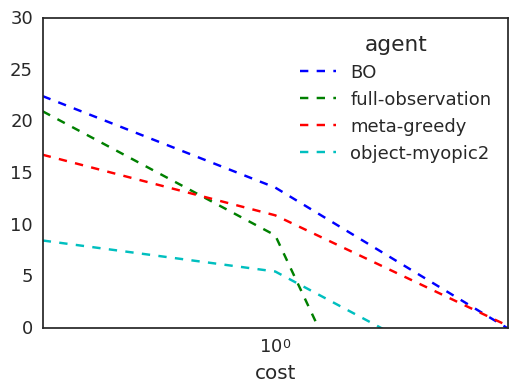

In [112]:
(df_stim.groupby(['cost','agent'])
    .util.mean().unstack()
    .plot(logx=True, ls='--', by='n_arm'))
plt.ylim(0)

# Object-level Pseudorewards

In [16]:
# Generating PRs
stimuli_envs = make_envs([4,1,2], reward, cost,n=16, ground_truth=1)

In [18]:
env = stimuli_envs[i]

In [28]:
env.observation_space

Box(17,)

In [82]:
prs = []
prs = np.empty((16,17,17))
dct={}
prs[:] = np.NAN
for i in range(1):
    subdct = {}
    env = stimuli_envs[i]
    for from_node in range(17):
        Q_max = env.true_Q(from_node)
        subdct[str(from_node)] = {}
        print(from_node, Q_max)
        for to_node in env.tree[from_node]:
            Q_curr = env.true_Q(to_node)        
            subdct[str(from_node)][str(to_node)] = Q_curr - Q_max
            prs[i,from_node,to_node] = Q_curr - Q_max
    dct[str(i)] = subdct

0 4.0
1 -4.0
2 0.0
3 -20.0
4 -4.0
5 -28.0
6 -16.0
7 -12.0
8 -4.0
9 4.0
10 8.0
11 -4.0
12 4.0
13 4.0
14 16.0
15 -20.0
16 4.0


In [80]:
print(prs)

[[ nan  -8.  nan  nan  nan -32.  nan  nan  nan   0.  nan  nan  nan   0.  nan  nan  nan]
 [ nan  nan   4.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan -20.  -4.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  12.  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan   4.  12.  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan   4.  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -12.  -4.  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan 

In [76]:
dct['0']['0']

{'1': -8.0, '13': 0.0, '5': -32.0, '9': 0.0}

In [66]:
np.save('prs',prs)

In [115]:
with open('pseudorewards', 'w') as f:
    json.dump(dct, f, indent=4)

In [116]:
lstprs = prs.tolist()
np.shape(lstprs)
for lst in lstprs:
    for sublst in lst:
        for i,n in enumerate(sublst):
            if np.isnan(n):
                sublst[i] = "_NaN_"

In [120]:
lstprs[0][0]

['_NaN_',
 -8.0,
 '_NaN_',
 '_NaN_',
 '_NaN_',
 -32.0,
 '_NaN_',
 '_NaN_',
 '_NaN_',
 0.0,
 '_NaN_',
 '_NaN_',
 '_NaN_',
 0.0,
 '_NaN_',
 '_NaN_',
 '_NaN_']

In [118]:
with open('pseudorewards_mat', 'w') as f:
    json.dump(lstprs, f, indent=4)

# Analysis

## Analysis of old results

(0, 25)

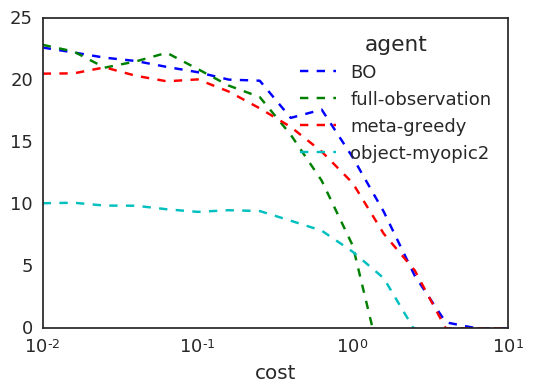

In [39]:
store = pd.HDFStore('results/testsom2.h5')
df = pd.concat([store['data'],store['sep_mg'],store['sep_bo']])
(df.groupby(['cost','agent'])
    .util.mean().unstack()
    .plot(logx=True, ls='--', by='n_arm'))
plt.ylim(0,25)

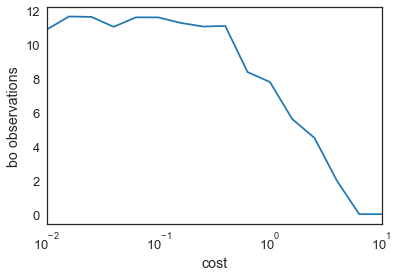

In [28]:
df[df.agent == 'BO'].groupby('cost').observations.mean().plot(logx=True)
plt.ylabel('bo observations')

In [48]:
bo = df[df.agent == 'BO']
om = df[df.agent == 'object-myopic2']
bobyc=bo.groupby('cost').util.mean()
ombyc=om.groupby('cost').util.mean()
bobyc-ombyc

cost
0.010000     12.555080
0.015849     12.118565
0.025119     11.928142
0.039811     11.671175
0.063096     11.479715
0.100000     11.263200
0.158489     10.533564
0.251189     10.512096
0.398107      8.292643
0.630957      9.761883
1.000000      7.610000
1.584893      5.365152
2.511886      4.407128
3.981072      6.617727
6.309573     15.094294
10.000000    30.480000
Name: util, dtype: float64